# Predicting Likelihood of Success with Logistic Regression

A logistic regression is an appropriate tool when model building with a binary outcome. By comparison, a multiple regression model tries to predict the value of a continous variable using a handlful of independent variables. 

The reason a logistic regression is the right choice for trying to predict lottery application success is it can use a set of variables to help it determine the likelihood of either a __success__ or a __failure__. This analysis attempts to build a model to help predict chances of success when selecting options for the Enchantments Lottery.

In [74]:
import pandas as pd

# Import the 2023_results_split.csv file
df_2023 = pd.read_csv(
    '../2023/2023_results_split.csv',
    # Import was failing to parse date columns, so I
    # to add the column names
    parse_dates=[
        "preferred_entry_date",
        "awarded_entry_date",
    ],
    date_format="%m-%d-%Y",  # Align format with export format
    na_filter=False,  # Do not convert 'N/A' to NaN
)

df_2023.head()

,preferred_zone,preferred_entry_date,minimum_acceptable_group_size,results_status,awarded_preference,awarded_entry_date,awarded_entrance_code_name,awarded_group_size,processing_sequence,state,awarded,preferred_option,preferred_entry_date_month,preferred_entry_date_day
0,Core Enchantment Zone,2023-06-18,2,Awarded,1,2023-06-18,Core Enchantment Zone,2,438,OR,True,1,June,Sunday
1,Core Enchantment Zone,2023-08-21,8,Unsuccessful,0,1970-01-01,N/A,0,16219,WA,False,1,August,Monday
2,Core Enchantment Zone,2023-06-09,4,Unsuccessful,0,1970-01-01,N/A,0,35433,WA,False,1,June,Friday
3,Core Enchantment Zone,2023-07-06,2,Unsuccessful,0,1970-01-01,N/A,0,22536,WA,False,1,July,Thursday
4,Core Enchantment Zone,2023-09-09,3,Unsuccessful,0,1970-01-01,N/A,0,31307,WA,False,1,September,Saturday


## Clean

In [75]:
awarded_less_than_preferred = (
    df_2023["awarded_preference"] <= df_2023["preferred_option"]
)

# Filter out rows where awarded preference is less than preferred option
df_2023 = df_2023[awarded_less_than_preferred]

# Remove state, awarded_group_size, awarded_entrance_code_name, awarded_entry_date, results_status
# minimum_acceptable_group_size, preferred_option, awarded_option
df_2023.drop(
    columns=[
        "state",
        "awarded_group_size",
        "awarded_entrance_code_name",
        "awarded_entry_date",
        "results_status",
        "preferred_option",
        "awarded_preference",
    ],
    inplace=True,
)

## Model Functions

During the modeling process a set of actions were being repeated between modeling the difference zones. Those actions became functions that were placed in the cell below.

In [76]:
from typing import Literal
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

# Filters the dataframe based on the preferred_zone
def filter_by_zone(df: pd.DataFrame, zone: Literal['Stuart  Zone', 'Core Enchantment Zone', 'Colchuck Zone', 'Snow Zone', 'Eightmile/Caroline Zone']) -> pd.DataFrame:
    return df[df["preferred_zone"] == zone].copy()

# Sorts the dataframe by the processing_sequence column
def sort_zone_df(df: pd.DataFrame) -> pd.DataFrame:
    # Sort the dataframe by the processing_sequence column
    df.sort_values(by="processing_sequence", inplace=True)

    # Reset the index of the dataframe
    df.reset_index(drop=True, inplace=True)

    return df

# Gets the number of rows, awarded, and percentage of awarded
def calculate_awarded(df: pd.DataFrame) -> tuple[int,int, float]:
    # Create a new column called awarded
    length = len(df)

    awarded: int = df["awarded"].sum()

    percentage = (awarded / length) * 100

    return length, awarded, percentage

# Gets the number of rows, awarded, and percentage of awarded
def dummy_vars(df: pd.DataFrame, column: Literal['preferred_entry_date_day', 'preferred_entry_date_month', 'preferred_zone', 'minimum_acceptable_group_size']) -> pd.DataFrame:
    return pd.get_dummies(df, columns=[column])

# Adds dummy columns for the zone dataframe
def add_zone_dummy_columns(df: pd.DataFrame, isCore: bool) -> pd.DataFrame:
    df = dummy_vars(df, 'preferred_entry_date_day')
    df = dummy_vars(df, 'preferred_entry_date_month')

    if isCore:
        df = dummy_vars(df, 'minimum_acceptable_group_size')
        
    return df

# Gets the feature variable columns for the dataframe as a list
def get_variable_columns(df: pd.DataFrame, includeProcessingSequence: bool) -> list[str]:
    # If the preferred zone is Core Enchantment Zone
    if df['preferred_zone'].iloc[0] == 'Core Enchantment Zone':
        cols = [col for col in df.columns if col.startswith('preferred_entry_date_day_') or col.startswith('preferred_entry_date_month_') or col.startswith('minimum_acceptable_group_size_')]
        
        if includeProcessingSequence:
            cols.append('processing_sequence')
        
        return cols

    # If the preferred zone is Stuart Zone
    else:
        cols = [col for col in df.columns if col.startswith('preferred_entry_date_day_') or col.startswith('preferred_entry_date_month_')]
            
        if includeProcessingSequence:
            cols.append('processing_sequence')
        
        return cols

# Builds the logistic regression model
def get_classification_report(df: pd.DataFrame, features: list[str], class_weight: dict[bool, int] | Literal['balanced'] | None, penalty: Literal['l1', 'l2', 'none'] | None) -> None:
    # Define the features and target variable
    X = df[features] # features
    y = df['awarded'] # target variable

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Create and fit the logistic regression model
    model = LogisticRegression(max_iter=10000, class_weight=class_weight, penalty=penalty)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Print the classification report
    print(classification_report(y_test, y_pred, zero_division=0))

    # Print the logistic regression equation coefficients
    print(f"Intercept: {model.intercept_[0]}")
    print(f"Coefficient: {model.coef_[0][0]}")

    # View the coefficients of the logistic regression model with labels
    coefficients = pd.DataFrame({
        'Variable': ['Intercept'] + X.columns.tolist(),
        'Coefficient': [model.intercept_[0]] + model.coef_[0].tolist()
    })

    # Sort by the coefficient value
    coefficients = coefficients.sort_values('Coefficient', ascending=False)

    # Exponentiate the coefficients to interpret them in terms of odds
    odds_ratios = np.exp(model.coef_[0])

    # View the odds_ratio of the logistic regression model with labels
    odds_ratios_df = pd.DataFrame({
        'Variable': X.columns.tolist(),
        'Odds Ratio': odds_ratios
    })

    # Sort by the odds ratio value
    odds_ratios_df = odds_ratios_df.sort_values('Odds Ratio', ascending=False)

    return model, coefficients, odds_ratios_df

def add_row_dummy_variables(new_row: pd.DataFrame) -> pd.DataFrame:
    if new_row['preferred_zone'].iloc[0] != 'Core Enchantment Zone':
        dummy_days = ['preferred_entry_date_day_Friday', 'preferred_entry_date_day_Monday', 'preferred_entry_date_day_Saturday', 'preferred_entry_date_day_Sunday', 'preferred_entry_date_day_Thursday', 'preferred_entry_date_day_Tuesday', 'preferred_entry_date_day_Wednesday']
        dummy_months = ['preferred_entry_date_month_August', 'preferred_entry_date_month_July', 'preferred_entry_date_month_June', 'preferred_entry_date_month_May', 'preferred_entry_date_month_October', 'preferred_entry_date_month_September']
        
        for day in dummy_days:
            new_row[day] = new_row['preferred_entry_date_day'] == day.split('_')[-1]
        
        for month in dummy_months:
            new_row[month] = new_row['preferred_entry_date_month'] == month.split('_')[-1]
    
    else:
        dummy_days_core = ['preferred_entry_date_day_Friday', 'preferred_entry_date_day_Monday', 'preferred_entry_date_day_Saturday', 'preferred_entry_date_day_Sunday', 'preferred_entry_date_day_Thursday', 'preferred_entry_date_day_Tuesday', 'preferred_entry_date_day_Wednesday']
        dummy_months_core = ['preferred_entry_date_month_August', 'preferred_entry_date_month_July', 'preferred_entry_date_month_June', 'preferred_entry_date_month_May', 'preferred_entry_date_month_October', 'preferred_entry_date_month_September']
        dummy_group_core = ['minimum_acceptable_group_size_1', 'minimum_acceptable_group_size_2', 'minimum_acceptable_group_size_3', 'minimum_acceptable_group_size_4', 'minimum_acceptable_group_size_5', 'minimum_acceptable_group_size_6', 'minimum_acceptable_group_size_7', 'minimum_acceptable_group_size_8']
        
        for day in dummy_days_core:
            new_row[day] = new_row['preferred_entry_date_day'] == day.split('_')[-1]
        
        for month in dummy_months_core:
            new_row[month] = new_row['preferred_entry_date_month'] == month.split('_')[-1]
        
        for group in dummy_group_core:
            new_row[group] = new_row['minimum_acceptable_group_size'] == int(group.split('_')[-1])
    
    return new_row

## Model Building

The Enchantment's Lottery process randomly selects applications and determines if permits are available given the entries' date, zone, and group size (group size only matters for the Core Enchantments Zone).

Each application has three entries. Each entry is evaluated independently. If one entry is selected and the applicant is awarded a permit then the applicant can not be awarded any more permits.

When building models it's important to note that an applicant's entry for a specific date and zone does not compete against __all__ of the other entries in the lottery. It competes against only the other entries for that zone. The Core Enchantment Zone gets the largest number of application entries and that zone's availability is determined by __people__ not by __groups__ on a given date. Additionally, most of the zones have a different number of group quotas.

Quotas for Enchantment Permit Zones:
- Core Enchantment Zone:  24 people per day*
- Colchuck Zone: 3 groups per day
- Stuart Zone: 4 groups per day
- Snow Zone: 5 groups per day
- Eightmile / Caroline Zone: 3 groups per day

Consequently, I could have built a model looking at the entire dataset as a whole (I may still). Instead, I broke the models down into their respective zones (Core Enchantments Zone, Stuart Zone, Snow Zone, etc.). 

### Stuart Zone

In [77]:
# Filter the dataframe to only include the Stuart Zone
df_2023_stuart = filter_by_zone(df_2023, 'Stuart  Zone')

# Print the length of the dataframe
print(f"Length of the dataframe: {len(df_2023_stuart)}")

df_2023_stuart.head()


Length of the dataframe: 7053


,preferred_zone,preferred_entry_date,minimum_acceptable_group_size,processing_sequence,awarded,preferred_entry_date_month,preferred_entry_date_day
13,Stuart Zone,2023-07-22,8,31674,False,July,Saturday
17,Stuart Zone,2023-07-10,3,28415,False,July,Monday
46,Stuart Zone,2023-08-06,4,31148,False,August,Sunday
92,Stuart Zone,2023-07-29,6,2264,True,July,Saturday
123,Stuart Zone,2023-08-18,4,22625,False,August,Friday


In [78]:
# Sort the dataframe
df_2023_stuart = sort_zone_df(df_2023_stuart)

length, awarded_rows, percentage = calculate_awarded(df_2023_stuart)

# Print the length of the dataframe
print(f'Length of the dataframe: {length}')

# Print the number of awarded rows
print(f'Number of awarded rows: {awarded_rows}')

# Print the percentage of successful applications
print(f'Percentage of successful applications: {percentage:.2f}%')



Length of the dataframe: 7053
Number of awarded rows: 480
Percentage of successful applications: 6.81%


In [79]:
df_2023_stuart = add_zone_dummy_columns(df_2023_stuart, False)

df_2023_stuart.head()

,preferred_zone,preferred_entry_date,minimum_acceptable_group_size,processing_sequence,awarded,preferred_entry_date_day_Friday,preferred_entry_date_day_Monday,preferred_entry_date_day_Saturday,preferred_entry_date_day_Sunday,preferred_entry_date_day_Thursday,preferred_entry_date_day_Tuesday,preferred_entry_date_day_Wednesday,preferred_entry_date_month_August,preferred_entry_date_month_July,preferred_entry_date_month_June,preferred_entry_date_month_May,preferred_entry_date_month_October,preferred_entry_date_month_September
0,Stuart Zone,2023-09-24,2,12,False,False,False,False,True,False,False,False,False,False,False,False,False,True
1,Stuart Zone,2023-06-29,4,20,True,False,False,False,False,True,False,False,False,False,True,False,False,False
2,Stuart Zone,2023-08-04,2,20,False,True,False,False,False,False,False,False,True,False,False,False,False,False
3,Stuart Zone,2023-09-05,4,24,False,False,False,False,False,False,True,False,False,False,False,False,False,True
4,Stuart Zone,2023-07-01,3,25,False,False,False,True,False,False,False,False,False,True,False,False,False,False


In [80]:
model_1, coefficients_1, odds_ratios_df_1 = get_classification_report(df_2023_stuart, get_variable_columns(df_2023_stuart, False), None, None)

odds_ratios_df_1


              precision    recall  f1-score   support

       False       0.92      1.00      0.96      1935
        True       0.67      0.01      0.02       181

    accuracy                           0.91      2116
   macro avg       0.79      0.51      0.49      2116
weighted avg       0.89      0.91      0.88      2116

Intercept: -1.6401167323178485
Coefficient: -0.9475215051992782


,Variable,Odds Ratio
10,preferred_entry_date_month_May,4.249208
3,preferred_entry_date_day_Sunday,1.659852
11,preferred_entry_date_month_October,1.590958
6,preferred_entry_date_day_Wednesday,1.129722
5,preferred_entry_date_day_Tuesday,1.120815
9,preferred_entry_date_month_June,1.018258
1,preferred_entry_date_day_Monday,0.898347
4,preferred_entry_date_day_Thursday,0.673373
2,preferred_entry_date_day_Saturday,0.393491
0,preferred_entry_date_day_Friday,0.387701


One of the first ways we can tweak the model is to test different class weights, assigning values to __False__ and __True__. Due to our poor performance in the first model we'll assign more weight to __True__ class.

In [81]:
class_weights = { False: 0.5, True: 2 }

In [82]:
model_2, coefficients_2, odds_ratios_df_2 = get_classification_report(df_2023_stuart, get_variable_columns(df_2023_stuart, False), class_weights, 'l2')

odds_ratios_df_2

              precision    recall  f1-score   support

       False       0.93      0.97      0.95      1935
        True       0.41      0.19      0.26       181

    accuracy                           0.91      2116
   macro avg       0.67      0.58      0.60      2116
weighted avg       0.88      0.91      0.89      2116

Intercept: -0.6291822642842757
Coefficient: -0.7464146678041217


,Variable,Odds Ratio
10,preferred_entry_date_month_May,4.334215
11,preferred_entry_date_month_October,1.920136
3,preferred_entry_date_day_Sunday,1.881052
5,preferred_entry_date_day_Tuesday,1.290315
6,preferred_entry_date_day_Wednesday,1.274574
9,preferred_entry_date_month_June,1.223249
1,preferred_entry_date_day_Monday,0.996216
4,preferred_entry_date_day_Thursday,0.799938
2,preferred_entry_date_day_Saturday,0.499296
12,preferred_entry_date_month_September,0.486761


Although I was able to determine an appropriate class_weight, an easier way to get proportional weights is to pass `balanced` as the argument for the `class_weight`. Per __scikit-learn__ documentation:

>Weights associated with classes in the form {class_label: weight}. If not given, all classes are supposed to have weight one.
>
>The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)).

We can get a similar result for our __True__ class by passing in `balanced` that we got when using our custom class weights.

In [83]:
model_2, coefficients_2, odds_ratios_df_2 = get_classification_report(df_2023_stuart, get_variable_columns(df_2023_stuart, False), 'balanced', 'l2')

odds_ratios_df_2

              precision    recall  f1-score   support

       False       0.95      0.70      0.81      1935
        True       0.16      0.62      0.26       181

    accuracy                           0.69      2116
   macro avg       0.56      0.66      0.53      2116
weighted avg       0.88      0.69      0.76      2116

Intercept: 0.42218990325987815
Coefficient: -0.5889587413296962


,Variable,Odds Ratio
10,preferred_entry_date_month_May,4.927814
11,preferred_entry_date_month_October,2.259899
3,preferred_entry_date_day_Sunday,2.124203
5,preferred_entry_date_day_Tuesday,1.471903
6,preferred_entry_date_day_Wednesday,1.417381
9,preferred_entry_date_month_June,1.394343
1,preferred_entry_date_day_Monday,1.071105
4,preferred_entry_date_day_Thursday,0.940205
2,preferred_entry_date_day_Saturday,0.601757
12,preferred_entry_date_month_September,0.578737


Using just the month and date columns yield fairly poor results for the __True__ class and its corresponding F1 score. The F1 score is a combination of recall and precision. Recall and precision are based on true positives, false positives, false negatives, and true negatives:
- True positive, the entry was awarded a permit, and we predicted it would be awarded a permit
- False positive, the entry was not awarded a permit, and we predictd it would be awarded a permit.
- False negative, the entry was awarded a permit, and we predicted it would not be awarded a permit.
- True negative, the entry was not awarded a permit, and we predicted it would not be awarded a permit.

__Precision__ is true positives / (true positives + false positives).
__Recall__ is true positives / (true positive  + false negatives).

With __precision__, if we're over predicting positives our precision number will suffer.
For __recall__, if we're predicting false values when we should be predicting true values this number will suffer.

The F1 score is calculated by multiplying 2 * precision * recall and dividing that number by (p + r). For example, if precision = 0.41 and recall = 0.19:

2 * 0.41 * 0.19 = 0.1558

0.1558 / (0.41 + 0.19)

0.1558 / 0.6 = 0.26

Our goal is to get the F1 score for the __True__ class above 0.80. However, I am satisfied if we get it about 0.50.

#### Processing Sequence

I chose to use the 2023 data to fit the models for two reasons:
1. It's the most recent dataset
2. It has the `processing_sequence` column

The processing sequence is the order that the selection algorithm saw the applications in. If the processing sequence is low, it means the application was selected early. If the processing sequence is high, the application was selected late and it's chance of winning was less.

Next, I want to look at our the model for the Stuart Zone but add in the processing sequence column as part of the model.

In [84]:
model_3, coefficients_3, odds_ratios_df_3 = get_classification_report(df_2023_stuart, get_variable_columns(df_2023_stuart, True), class_weights, None)

odds_ratios_df_3

              precision    recall  f1-score   support

       False       0.97      0.94      0.96      1935
        True       0.53      0.68      0.60       181

    accuracy                           0.92      2116
   macro avg       0.75      0.81      0.78      2116
weighted avg       0.93      0.92      0.93      2116

Intercept: 2.0821238541395988
Coefficient: -0.7680361035781863


,Variable,Odds Ratio
10,preferred_entry_date_month_May,63.392429
11,preferred_entry_date_month_October,7.297414
3,preferred_entry_date_day_Sunday,3.282993
6,preferred_entry_date_day_Wednesday,2.595710
5,preferred_entry_date_day_Tuesday,2.290644
1,preferred_entry_date_day_Monday,1.694206
9,preferred_entry_date_month_June,1.632084
13,processing_sequence,0.999743
4,preferred_entry_date_day_Thursday,0.986131
2,preferred_entry_date_day_Saturday,0.530181


In addition to using the `processing_sequence` column in the model I also went back to using the custom `class_weights`. The processing sequence column greatly improved the F1 score of our model pushing it above 0.50 and getting it all the way to 0.60 for the __True__ class in the Stuart Zone!

### Odds Ratio

The odds ratio is interpreted as a _factor_. Anything above 1.0 is said to _increase the odds by a factor of [x]_ and anything below 1.0 is said to _decrease the odds by a factor of [x]_. For our purposes, we're ranking the odds factor to see what's helping the odds for an application and what's hurting the odds. 

No surprise that applications for August, July, Septemeber, Friday, Saturday, and Thursday are hurting the odds. Conversely, we could have intuited that applications for May, October, Wednesday, Tuesday, and Monday would help.

>Sunday is the dark horse because in 2023 it was given more inventory for the lottery, and in 2024 both Sunday and Monday received increased inventory compared to other days due to no walk-lotteries offered for those days

What's interesting about the odds ratio is it gives us the factor increases that the logistic regression found which helps us get a sense of just how much each choice can impact the entries chance by comparison. Remember, this is just for the Stuart Zone but we can say if you want to win a permit for the Stuart Zone you'll increase your odds signficantly by selecting a Sunday in May or October.

Later, I'll talk about how we can use the models predictive function to stratify our application's entries given the processing sequence that we may receive. 

### Core Enchantment Zone

The Core Enchantment Zone Lottery operates different than other zones. Instead of _groups_ the Core Enchantment permits are awarded by people. Consequently, group size plays a big factor in determining if an application is awarded a permit. I'll again split the entries by processing sequence to see if we have a difference in our ability to predict successful entries.

In [85]:
# Filter the df_2023 to only include the Core Enchantment Zone
df_2023_core = filter_by_zone(df_2023, 'Core Enchantment Zone')

# Sort the dataframe
df_2023_core = sort_zone_df(df_2023_core)

# Calculate awarded
length, awarded_rows, percentage = calculate_awarded(df_2023_core)

# Print the total length of the dataframe
print(f'Length of the dataframe: {length}')

# Print the number of awarded rows
print(f'Number of awarded rows: {awarded_rows}')

# Print the percentage of successful applications
print(f'Percentage of successful applications: {percentage:.2f}%')

df_2023_core = add_zone_dummy_columns(df_2023_core, True)

Length of the dataframe: 74483
Number of awarded rows: 737
Percentage of successful applications: 0.99%


The Core Enchantment Zone has the added feature column of group size to help predict the outcome.

In [86]:
# Get the classification report for the first half of the df_2023_core dataframe
model_4, coefficients_4, odds_ratios_df_4 = get_classification_report(df_2023_core, get_variable_columns(df_2023_core, True), class_weights, None)

odds_ratios_df_4


              precision    recall  f1-score   support

       False       0.99      0.99      0.99     22131
        True       0.32      0.32      0.32       214

    accuracy                           0.99     22345
   macro avg       0.65      0.66      0.66     22345
weighted avg       0.99      0.99      0.99     22345

Intercept: 0.6407228582568314
Coefficient: -0.5220610023944904


,Variable,Odds Ratio
13,minimum_acceptable_group_size_1,19.543765
10,preferred_entry_date_month_May,16.427626
11,preferred_entry_date_month_October,2.349835
3,preferred_entry_date_day_Sunday,2.128082
9,preferred_entry_date_month_June,1.634493
5,preferred_entry_date_day_Tuesday,1.373725
6,preferred_entry_date_day_Wednesday,1.229324
1,preferred_entry_date_day_Monday,1.112942
14,minimum_acceptable_group_size_2,1.107989
21,processing_sequence,0.999530


This is an underperforming model, despite having more independent variables to use a features. Although it's underperforming, the odds ratios seem on par with our Stuart Zone model.

One idea I had for increasing the F1 score, and possibly over fitting the model, is to shrink the pool of entries by processing sequence. The Core Enchantment Zone is so competitive that a __huge__ number of entries are rejected. My intuition is that this causes the model to get a lot wrong. But, if we looked at entries in the first or first quarter of the lottery based on processing sequence, maybe we get get better results?

In [87]:
# Filter the df_2023 dataframe to only include the Core Enchantment Zone
df_2023_core_first_1500 = filter_by_zone(df_2023, 'Core Enchantment Zone')

# Sort the dataframe
df_2023_core_first_1500 = sort_zone_df(df_2023_core_first_1500)

# Filter the df_2023_core_first_1500 dataframe to only include the first 1500 processing_sequence values
df_2023_core_first_1500 = df_2023_core_first_1500[df_2023_core_first_1500['processing_sequence'] <= 1500].copy()

# Calculate awarded
length, awarded_rows, percentage = calculate_awarded(df_2023_core_first_1500)

# Print the total length of the dataframe
print(f'Length of the dataframe: {length}')

# Print the number of awarded rows
print(f'Number of awarded rows: {awarded_rows}')

# Print the percentage of successful applications
print(f'Percentage of successful applications: {percentage:.2f}%')

# Create dummy vars for the minimum_acceptable_group_size column
df_2023_core_first_1500 = add_zone_dummy_columns(df_2023_core_first_1500, True)

# Get the classification report for the df_2023_core_spots dataframe
model_5, coefficients_5, odds_ratios_df_5 = get_classification_report(df_2023_core_first_1500, get_variable_columns(df_2023_core_first_1500, True), 'balanced', None)

odds_ratios_df_5

Length of the dataframe: 2414
Number of awarded rows: 517
Percentage of successful applications: 21.42%
              precision    recall  f1-score   support

       False       0.90      0.69      0.78       572
        True       0.37      0.70      0.49       153

    accuracy                           0.69       725
   macro avg       0.63      0.69      0.63       725
weighted avg       0.79      0.69      0.72       725

Intercept: 1.6770994276731057
Coefficient: -0.1483286591743394


,Variable,Odds Ratio
10,preferred_entry_date_month_May,7.641726
13,minimum_acceptable_group_size_1,2.972054
9,preferred_entry_date_month_June,2.729939
3,preferred_entry_date_day_Sunday,2.722829
11,preferred_entry_date_month_October,1.951933
14,minimum_acceptable_group_size_2,1.757686
5,preferred_entry_date_day_Tuesday,1.669578
6,preferred_entry_date_day_Wednesday,1.406604
15,minimum_acceptable_group_size_3,1.244076
1,preferred_entry_date_day_Monday,1.243606


It wasn't until I filtered for the processing sequence values of less than 1500 (i.e., the first 1500 applications for the lottery) before I got both the __True__ class F1 score to 0.49 and kept the __False__ class F1 score above 0.50. Remarkably, this dataframe consists of 2414 entries, of which __517__ were awarded. To break this down further:

There were 40,000 applications for the Enchantments Lottery, each application could have three entries. Subsequently, processing sequence values ranged from 1-40000.
- 74,483 entries were for the Core Enchantment Zone, of which 737 were awarded.
- 517 of the 737 Core Enchantment Zone permits were awarded in the first 1500 applications.
- 70% of Core Enchantment Zone permits were awarded in the first 3.75% of applications
- 91% of Core Enchantment Zone permits were awarded in the first 12.5% (5000) of applications

In fact, looking at the total inventory of Core Enchantment Zone permits, there were only a handful of days that were not fully booked during the lottery process. The below lists shows the date and the number of left-over permits not claimed during the lottery for the Core Enchantment Zone:

- 2023-05-16: 1
- 2023-05-25: 1
- 2023-06-01: 1
- 2023-06-20: 1
- 2023-06-26: 1
- 2023-10-23: 1
- 2023-10-25: 1
- 2023-10-26: 1
- 2023-10-29: 18
- 2023-10-30: 6
- 2023-10-31: 14

### Snow Zone

In [88]:
# Fit a model for the Snow Zone like we fit for the Stuart Zone
df_2023_snow = filter_by_zone(df_2023, 'Snow Zone')

# Sort the dataframe
df_2023_snow = sort_zone_df(df_2023_snow)

# Calculate awarded
length, awarded_rows, percentage = calculate_awarded(df_2023_snow)

# Print the total length of the dataframe
print(f'Length of the dataframe: {length}')

# Print the number of awarded rows
print(f'Number of awarded rows: {awarded_rows}')

# Print the percentage of successful applications
print(f'Percentage of successful applications: {percentage:.2f}%')

# Create dummy vars for the minimum_acceptable_group_size column
df_2023_snow = add_zone_dummy_columns(df_2023_snow, False)

Length of the dataframe: 13043
Number of awarded rows: 652
Percentage of successful applications: 5.00%


In [89]:
# Get the classification report for the df_2023_snow dataframe
model_6, coefficients_6, odds_ratios_df_6 = get_classification_report(df_2023_snow, get_variable_columns(df_2023_snow, True), { False: 0.4, True: 2 }, None)

odds_ratios_df_6

              precision    recall  f1-score   support

       False       0.98      0.94      0.96      3718
        True       0.39      0.70      0.50       195

    accuracy                           0.93      3913
   macro avg       0.69      0.82      0.73      3913
weighted avg       0.95      0.93      0.94      3913

Intercept: 1.9577633117325401
Coefficient: -0.36647159697255643


,Variable,Odds Ratio
10,preferred_entry_date_month_May,64.339911
11,preferred_entry_date_month_October,8.811027
3,preferred_entry_date_day_Sunday,1.868395
6,preferred_entry_date_day_Wednesday,1.804476
9,preferred_entry_date_month_June,1.719647
5,preferred_entry_date_day_Tuesday,1.636447
1,preferred_entry_date_day_Monday,1.596423
2,preferred_entry_date_day_Saturday,1.128197
4,preferred_entry_date_day_Thursday,1.028365
13,processing_sequence,0.999749


### Colchuck Zone

In [90]:
# Fit a model for the Colchuck Zone like we fit for the Stuart Zone
df_2023_colchuck = filter_by_zone(df_2023, 'Colchuck Zone')

# Sort the dataframe
df_2023_colchuck = sort_zone_df(df_2023_colchuck)

# Calculate awarded
length, awarded_rows, percentage = calculate_awarded(df_2023_colchuck)

# Print the total length of the dataframe
print(f'Length of the dataframe: {length}')

# Print the number of awarded rows
print(f'Number of awarded rows: {awarded_rows}')

# Print the percentage of successful applications
print(f'Percentage of successful applications: {percentage:.2f}%')

Length of the dataframe: 18459
Number of awarded rows: 354
Percentage of successful applications: 1.92%


In [91]:
# Create dummy vars for the minimum_acceptable_group_size column
df_2023_colchuck = add_zone_dummy_columns(df_2023_colchuck, False)

# Get the classification report for the df_2023_colchuck dataframe
model_7, coefficients_7, odds_ratios_df_7 = get_classification_report(df_2023_colchuck, get_variable_columns(df_2023_colchuck, True), class_weights, None)

odds_ratios_df_7

              precision    recall  f1-score   support

       False       0.99      0.99      0.99      5432
        True       0.42      0.42      0.42       106

    accuracy                           0.98      5538
   macro avg       0.70      0.71      0.71      5538
weighted avg       0.98      0.98      0.98      5538

Intercept: 1.0269260249504395
Coefficient: -0.5320697782563305


,Variable,Odds Ratio
10,preferred_entry_date_month_May,14.497721
11,preferred_entry_date_month_October,7.462773
3,preferred_entry_date_day_Sunday,2.409304
5,preferred_entry_date_day_Tuesday,1.635913
6,preferred_entry_date_day_Wednesday,1.475426
9,preferred_entry_date_month_June,1.107928
13,processing_sequence,0.999584
4,preferred_entry_date_day_Thursday,0.994687
1,preferred_entry_date_day_Monday,0.977341
2,preferred_entry_date_day_Saturday,0.840934


In [92]:
# Fit a similar model but filter the df_2023_colchuck dataframe to only include the first 10000 processing_sequence values
df_2023_colchuck_first_10000 = filter_by_zone(df_2023, 'Colchuck Zone')

# Sort the dataframe
df_2023_colchuck_first_10000 = sort_zone_df(df_2023_colchuck_first_10000)

# Filter the df_2023_colchuck_first_10000 dataframe to only include the first 10000 processing_sequence values
df_2023_colchuck_first_10000 = df_2023_colchuck_first_10000[df_2023_colchuck_first_10000['processing_sequence'] <= 10000].copy()

# Calculate awarded
length, awarded_rows, percentage = calculate_awarded(df_2023_colchuck_first_10000)

# Print the total length of the dataframe
print(f'Length of the dataframe: {length}')

# Print the number of awarded rows
print(f'Number of awarded rows: {awarded_rows}')

# Print the percentage of successful applications
print(f'Percentage of successful applications: {percentage:.2f}%')

# Create dummy vars for the minimum_acceptable_group_size column
df_2023_colchuck_first_10000 = add_zone_dummy_columns(df_2023_colchuck_first_10000, False)

# Get the classification report for the df_2023_colchuck_first_10000 dataframe
model_8, coefficients_8, odds_ratios_df_8 = get_classification_report(df_2023_colchuck_first_10000, get_variable_columns(df_2023_colchuck_first_10000, True), { False: 0.3, True: 2 }, None)

odds_ratios_df_8

Length of the dataframe: 4436
Number of awarded rows: 331
Percentage of successful applications: 7.46%
              precision    recall  f1-score   support

       False       0.98      0.87      0.92      1216
        True       0.38      0.82      0.52       115

    accuracy                           0.87      1331
   macro avg       0.68      0.84      0.72      1331
weighted avg       0.93      0.87      0.89      1331

Intercept: 2.2649408853470008
Coefficient: -0.6340667196686622


,Variable,Odds Ratio
10,preferred_entry_date_month_May,35.223729
11,preferred_entry_date_month_October,13.305139
3,preferred_entry_date_day_Sunday,3.244245
6,preferred_entry_date_day_Wednesday,1.968005
5,preferred_entry_date_day_Tuesday,1.850134
1,preferred_entry_date_day_Monday,1.238509
9,preferred_entry_date_month_June,1.233533
4,preferred_entry_date_day_Thursday,1.114187
2,preferred_entry_date_day_Saturday,1.113839
13,processing_sequence,0.999195


### Eightmile/Caroline Zone

In [93]:
# Fit a model for Eightmile/Caroline Zone like we fit for the Stuart Zone
df_2023_eightmile = filter_by_zone(df_2023, 'Eightmile/Caroline Zone')

# Sort the dataframe
df_2023_eightmile = sort_zone_df(df_2023_eightmile)

# Calculate awarded
length, awarded_rows, percentage = calculate_awarded(df_2023_eightmile)

# Print the total length of the dataframe
print(f'Length of the dataframe: {length}')

# Print the number of awarded rows
print(f'Number of awarded rows: {awarded_rows}')

# Print the percentage of successful applications
print(f'Percentage of successful applications: {percentage:.2f}%')

# Create dummy vars for the minimum_acceptable_group_size column
df_2023_eightmile = add_zone_dummy_columns(df_2023_eightmile, False)

Length of the dataframe: 2401
Number of awarded rows: 289
Percentage of successful applications: 12.04%


In [94]:
# Get the classification report for the df_2023_eightmile dataframe
model_9, coefficients_9, odds_ratios_df_9 = get_classification_report(df_2023_eightmile, get_variable_columns(df_2023_eightmile, True), { False: 1, True: 2 }, None)

odds_ratios_df_9

              precision    recall  f1-score   support

       False       0.94      0.91      0.93       635
        True       0.49      0.60      0.54        86

    accuracy                           0.88       721
   macro avg       0.72      0.76      0.74       721
weighted avg       0.89      0.88      0.88       721

Intercept: 1.3938376654195526
Coefficient: -0.586183965582596


,Variable,Odds Ratio
10,preferred_entry_date_month_May,6.785376
11,preferred_entry_date_month_October,5.356054
3,preferred_entry_date_day_Sunday,2.520981
6,preferred_entry_date_day_Wednesday,2.159992
9,preferred_entry_date_month_June,1.979930
4,preferred_entry_date_day_Thursday,1.306790
1,preferred_entry_date_day_Monday,1.269336
5,preferred_entry_date_day_Tuesday,1.102038
13,processing_sequence,0.999826
2,preferred_entry_date_day_Saturday,0.727632


## Predicting Entry Probabilities

Now that we have fit models for each of the zones that have F1 scores of at least 0.50 for the __True__ class we can do the fun stuff. Using our models we make predictions and look at the probabilities of different combinations for dates, zones, and group sizes in 2025. 

Although the predictons from the models are fun to look at, I must say these models have bare minimum F1 scores meaning they aren't that good at predicting __True__ entries. On the other hand, they're not entirely bad and can give us some insight as we develop strategies for application entries and try to maximize those entries' potential.

### Functions

In [95]:
import matplotlib.pyplot as plt

# Create a new dataframe row with the dummy variables for a given entry_date, preferred_zone, group_size, and processing_sequence
def build_row(entry_date: str, preferred_zone: str, group_size: int, processing_sequence: int) -> dict:
    entry_date = pd.to_datetime(entry_date)

    df = pd.DataFrame([{
        'preferred_zone': preferred_zone,
        'preferred_entry_date': entry_date,
        'minimum_acceptable_group_size': group_size,
        'processing_sequence': processing_sequence,
        'preferred_entry_date_month': entry_date.strftime('%B'),
        'preferred_entry_date_day': entry_date.strftime('%A')
    }])

    df = add_row_dummy_variables(df)

    return df


# Function for selecting the model based on the preferred zone
def select_model(preferred_zone: str) -> LogisticRegression:
    if preferred_zone == 'Stuart  Zone':
        return model_3
    elif preferred_zone == 'Core Enchantment Zone':
        return model_5
    elif preferred_zone == 'Colchuck Zone':
        return model_8
    elif preferred_zone == 'Snow Zone':
        return model_6
    elif preferred_zone == 'Eightmile/Caroline Zone':
        return model_9
    else:
        raise ValueError('Invalid preferred_zone')
    
def application_probability(entry_date: str, preferred_zone: str, group_size: int, processing_sequence: int, log = False) -> float:
    # Build the row
    row = build_row(entry_date, preferred_zone, group_size, processing_sequence)

    # Get the columns that are used in the model
    columns = get_variable_columns(row, True)

    # Get the features
    X = row[columns]

    model = select_model(preferred_zone)

    # Make predictions
    y_pred = model.predict(X)

    # Make predictions
    y_pred_proba = model.predict_proba(X)

    if log:
        # Print the prediction for True
        print(f'Probability of true: {y_pred_proba[0][1]}')

        # Print the prediction for False
        print(f'Probability of false: {y_pred_proba[0][0]}')

        # Print the prediction
        print(f'Prediction: {y_pred[0]}')

    return y_pred_proba[0][1]

def plot_probability(entry_date: str, preferred_zone: str, group_size: int):
    # Create an empty list to store the probabilities
    probabilities = []

    # Loop through the processing_sequence values from 1 to 40000
    for i in range(1, 40001, 500):
        # Predict the probability of the application being awarded
        probability = application_probability(entry_date, preferred_zone, group_size, i)

        # Append the probability to the list
        probabilities.append(probability)

    # Plot the probabilities
    plt.plot(range(1, 40001, 500), probabilities)

    # Add labels and title
    plt.xlabel('Processing Sequence')
    plt.ylabel('Probability of Awarded')

    plt.title('Probability of Awarded vs. Processing Sequence')

    # Keep the y-axis between 0 and 1
    plt.ylim(0, 1)

    # Display the y-axis as percentage
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))

    # Show grid lines for the y-axis
    plt.grid(axis='y')

    # Display the plot
    plt.show()


Equipped with our functions we can get the probability of our application winning for a Saturday in June, for the Core Enchantment Zone, with a group size of 1. The last argument we pass in is the processing sequence value to gauge how the application will do depending on when it's chosen.

```python
application_probability('2025-06-07', 'Core Enchantment Zone', 1, 2000)
```

In the above example we want to determine the probability for an entry on Saturday, June 7, 2025 in the Core Enchantment Zone with a group size of one that's processed as the 2000 application in the lottery. The probability for this application is:
```
0.17237437047750997
```

However, if we change the processing sequence to 5000:

```python
application_probability('2025-06-07', 'Core Enchantment Zone', 1, 5000)
```

We get a probability close to zero:
```
0.00007281371080709937
```

Using the odds ratio charts from early we know two ways to increase these odds:
1. Day of week
2. Month

Instead of selecting a Saturday in June we can select a Sunday in May:
```python
application_probability('2025-05-25', 'Core Enchantment Zone', 1, 5000)
```

The subsequent probability is:
```
0.0005737435502421827
```

Here we see just how critical the processing sequence value is depending on the Zone. Instead of the Core Enchantment Zone, let's look at the Stuart Zone with similar parameters. Remember, in the Stuart Zone group size doesn't matter:

```python
application_probability('2025-06-07', 'Stuart  Zone', 1, 5000)
```

All we did was change the zone and the probability shot up to 65%:
```
0.6576866545264854
```


#### Plotting Probabilities by Processing Sequence

The next step is building and comparing selections and plotting those probabilities based on the processing sequence value. Using the processing sequence to plot the probabilities can help us employ an application strategy of stratification.

Instead of going all in for low probability picks where the probability of success in essentially 0 if our application is selected outside the first 10,000, we can make selections that maximize our probabilities even if our processing sequence is in the middle or late.

Let's look at a couple combinations of entries for an application.

```python
plot_probability('2025-07-27', 'Core Enchantment Zone', 2) # Sunday, July, Core Zone
plot_probability('2025-07-27', 'Colchuck Zone', 4) # Sunday, July, Colchuck Zone
plot_probability('2025-07-27', 'Stuart  Zone', 3) # Sunday, July, Stuart Zone
plot_probability('2025-10-01', 'Snow Zone', 3) # October, Wednesday, Snow Zone
```


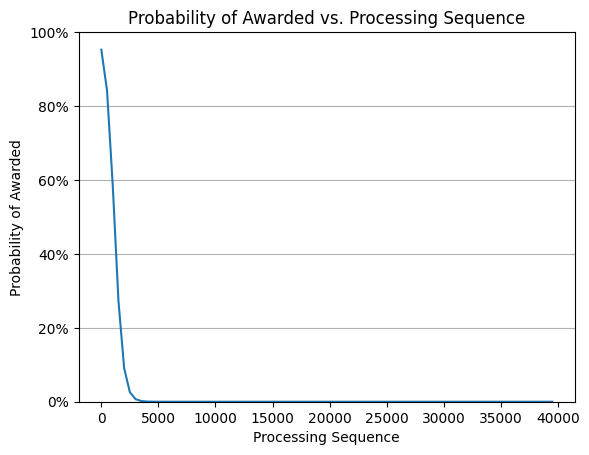

In [96]:
# Plot the probability of being awarded for the Core Enchantment Zone on a Saturday with a group size of 1 in June 2025
plot_probability('2025-07-27', 'Core Enchantment Zone', 2)

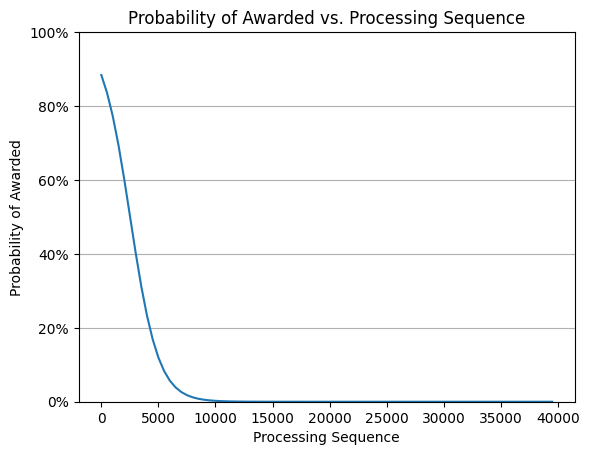

In [97]:
plot_probability('2025-07-27', 'Colchuck Zone', 4)

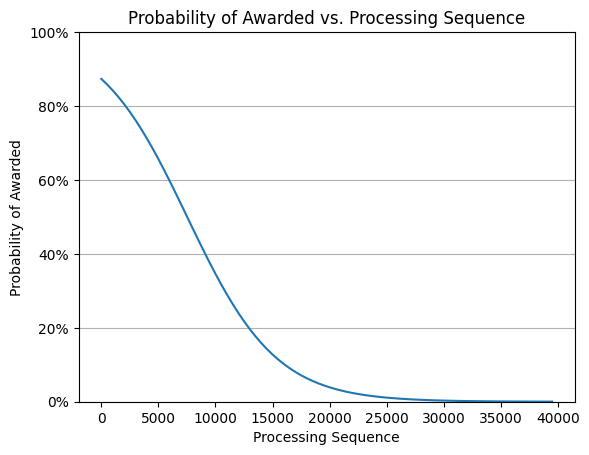

In [98]:
plot_probability('2025-07-27', 'Stuart  Zone', 3)

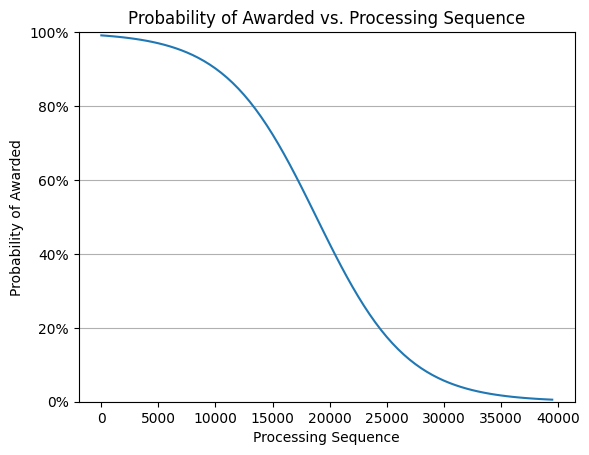

In [99]:
plot_probability('2025-10-01', 'Snow Zone', 3)

I've written before that you shouldn't let these probabilities tell you what to do or when to apply. If you aren't going to enjoy a certain zone, or aren't comfortable backpacking at certain times of the year when conditions may be dangerous, you should apply for what you would enjoy and what you can handle.

However, even if you're bent on the Core Zone in August you should pay attention to the day of the week and group size because going on a Sunday with a group size of 1 has better chance of being awarded than a Saturday with a group size of 8.

On the other hand, if you're flexible on dates and interested in more than just the Colchuck and Core Zone we can do some cool things by plotting the probabilities.

#### Core and Colchuck are both very competitive

The Colchuck Zone and the Core Enchantment Zone are extremely competitive. I think most people view the Colchuck as a less competitive alternative to the Core Enchantment Zone but they're very similar. Therefore, I would argue for people not viewing the Colchuck Zone as giving them that much better of a shot and they should instead choose one or the other.

Conversely, taking a look at the same date in 2025 for the Core Enchantment Zone and Colchuck Zone someone could argue against my opinion.

```python
application_probability('2025-07-27', 'Core Enchantment Zone', 2, 2000, log=True) # Sunday, July, Core Zone
# 0.09087195538825434
application_probability('2025-07-27', 'Colchuck Zone', 4, 2000, log=True) # Sunday, July, Colchuck Zone
# 0.6035393631091973
```

The processing sequence for the Colchuck Zone would be need to be 5300 before these two application entries were similar:

```python
application_probability('2025-07-27', 'Colchuck Zone', 4, 2000, log=True)
# 0.09633555979800026
```

Despite differences in processing sequence values we're betting on our application being one of the first 5000 applications, which is pretty rare if there are 40,000+ applications. I think a better strategy is to stratify application options across different zones and dates to increase our chances of winning no matter the processing sequence.

Let's look at these three entry options that could potentially make up your Enchantments Lottery application:
1. '2025-07-27', 'Colchuck Zone', 4 - # Sunday, July, Colchuck Zone
2. '2025-07-27', 'Stuart  Zone', 3 - # Sunday, July, Stuart Zone
3. '2025-10-01', 'Snow Zone', 3 - # Wednesday, October, Snow Zone

Examining the plots for these three options (see the charts further up the analysis) the probabilities bottom out at later and later processing sequence numbers. I'll explain the reasoning behind each of these picks.

The __Colchuck Zone__ application is our first entry. __The plot bottoms out around 10,000 for the processing sequence.__ This is our unicorn. If our application gets very lucky we've selected a good month, day, and one of the most popular zones. The Colchuck Zone is arguably better than the Core Zone for a couple reasons, one of which being the Core Zone is pretty grueling backpack. Conversely, one could stay at the Colchuck Zone and day hike to the Core Zone saving some effort.

The __Stuart Zone__ application is the second entry. __This plot bottoms out around 25,000 for the processing sequence.__ The Stuart Zone is not near the Core Enchantment Zone. Actually, it's about a two-mile hike from Stuart Lake to Colchuck. Then, it's a few miles to get around Colchuck and up Aasgard to the Core Zone. That said, I went on a backpacking trip to Stuart Lake this past September (2024) and it was amazing. One of the best I've been on. We day hiked to Colchuck and to Horseshoe Lake, which was like having our own little Enchantments to ourselves cause no one else was up there.

The last entry is for the __Snow Zone__ in early October on a Wednesday. __This plot bottoms out around 40,000 for the processing sequence.__ Early October is potentially larch season, which means it can also get cold. The Snow Zone is similar elevation to the Colchuck Zone but has a higher quota than the Colchuck Zone meaning a better percentage chance of getting a permit. Like the Colchuck Zone, the Snow Zone is another gateway into the Core Enchantments for a day hike.

## Conclusion

Using a logistic regression model to predict Enchantment Lottery outcomes wasn't as successful in predicting applications as I had hoped. However, I was able to build a series of models that I felt good about. Similarly, the odds ratios matched up with previous analyses looking at the application types that performed the best. 

The Enchantments Lottery evolves every year. As previously mentioned, in 2024 the lottery quota was greater on Sundays and Mondays because of no walk-up lottery. Conversely, in 2023, it was only Sunday that had the increased lottery so in the future we can expect Sundays and Mondays to be similar in terms of being good options.

If I have the time it would be fun to put these models online and make the selections available so people can try to optimize their application entries.